# import library

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from tqdm.auto import tqdm

In [2]:
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
print(torch.__version__)

1.8.0


In [4]:
print(np.__version__)

1.23.1


# set pytorch gpu

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# notation

## bit definitions

In [6]:
%%html
<style>
table {float:left}
</style>

| box_value | box_name     |
|-----------|--------------|
| 0         | Empty        |
| 1         | BrownWood    |
| 2         | RedWood      |
| 3         | GreenWood    |
| 4         | BrownLeather |
| 5         | BrownPaper   |
| 6         | BlueSteel    |

# environment

In [7]:
class MoveTheBoxGameEnvironment:
    def __init__(
        self,
        board_height=9,
        board_width=7,
        unique_box_type=6,
        p_add_3_box=0.77,
        is_debug=False,
    ):

        # init parameter
        self.board_height = board_height
        self.board_width = board_width
        self.unique_box_type = unique_box_type
        self.p_add_3_box = p_add_3_box
        self.is_debug = is_debug

        # init color_map
        box_color_map_list = (
            np.array(
                [
                    [255, 255, 255],
                    [169, 133, 92],
                    [183, 71, 34],
                    [156, 164, 52],
                    [102, 65, 38],
                    [189, 140, 61],
                    [149, 165, 168],
                ]
            )
            / 255
        )
        self.box_color_map = LinearSegmentedColormap.from_list(
            "box_color_map",
            box_color_map_list,
            box_color_map_list.shape[0],
        )

        # init game
        self.cumulative_score = 0
        self.reset()

    def reset(self):
        self.createBoard()
        self.createAboveBoard()
        self.addAboveBox()
        self.aboveIncludeFall()
        self.cumulative_score = 0

    def createBoard(self):
        self.board = np.zeros(
            (self.board_height, self.board_width),
            dtype=np.int8,
        )

    def createAboveBoard(self):
        self.above_board = np.zeros(
            (1, self.board_width),
            dtype=np.int8,
        )

    def addAboveBox(self):
        number_of_box_above = np.random.choice(
            [3, 4], p=[self.p_add_3_box, 1 - self.p_add_3_box]
        )
        box_value = np.random.randint(
            low=1,
            high=self.unique_box_type + 1,
            size=number_of_box_above,
            dtype=np.int8,
        )
        aboveBox = np.zeros(
            self.board_width,
            dtype=np.int8,
        )
        aboveBox[:number_of_box_above] = 1
        aboveBox[aboveBox == 1] = box_value
        np.random.shuffle(aboveBox)
        self.above_board = aboveBox.reshape((1, self.board_width))

    def aboveIncludeFall(self):
        is_gameover = self.checkIsGameover()
        if is_gameover:
            return is_gameover
        temp_board = np.vstack((self.board, self.above_board)).copy()
        temp_board = self.fall(temp_board)
        self.above_board = temp_board[-1].reshape((1, self.board_width)).copy()
        self.board = temp_board[:-1].copy()
        self.addAboveBox()
        score = self.updateBoard()
        self.cumulative_score = self.cumulative_score + score
        if self.checkIsEmptyBoard():
            return self.aboveIncludeFall()
        return False

    # game mechanism
    def fall(self, temp_board):
        temp_board = temp_board.copy()
        for y in range(self.board_width):
            x = 0
            is_fall = False
            while x < temp_board.shape[0] - 1:
                # skip floor and run loop
                x += 1
                # check below is empty
                if not self.checkIsEmpty(temp_board[x, y]) and self.checkIsEmpty(
                    temp_board[x - 1, y]
                ):
                    # fall
                    temp_board[x - 1, y] = temp_board[x, y].copy()
                    temp_board[x, y] = 0
                    is_fall = True

                # reset and fall again
                if is_fall and (x >= temp_board.shape[0] - 1):
                    x = 0
                    is_fall = False
        return temp_board

    def remove(self, temp_board):
        temp_board = temp_board.copy()
        if self.is_debug:
            self.displayTempBoard(temp_board)
        remove_list = self.check(temp_board)
        numbers_of_remove = np.unique(remove_list, axis=0).shape[0]
        if self.is_debug:
            print(f"remove_list : {remove_list}")
            print(f"number of remove box (remove): {numbers_of_remove}")
        numbers_of_remove_recursive = []
        if len(remove_list) > 0:
            for remove_index in remove_list:
                temp_board[remove_index[0], remove_index[1]] = 0
            temp_board = self.fall(temp_board)
            temp_board, numbers_of_remove_recursive = self.remove(temp_board)
        return temp_board, [numbers_of_remove] + numbers_of_remove_recursive

    def check(self, temp_board):
        remove_list = []
        for x in range(temp_board.shape[0]):
            remove_list = remove_list + self.checkRow(temp_board, x)

        for y in range(temp_board.shape[1]):
            remove_list = remove_list + self.checkCol(temp_board, y)
        return remove_list

    def checkRow(self, temp_board, x):
        count = 1
        last_found = temp_board[x, 0]
        remove_list = []
        is_change = False

        for y in range(1, temp_board.shape[1]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if y >= temp_board.shape[1] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True

            if is_change:
                if not self.checkIsEmpty(temp_board[x, y - 1]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x, y - i - 1])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    def checkCol(self, temp_board, y):
        count = 1
        last_found = temp_board[0, y]
        remove_list = []
        is_change = False
        for x in range(1, temp_board.shape[0]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if x >= temp_board.shape[0] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True
            if is_change:
                if not self.checkIsEmpty(temp_board[x - 1, y]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x - i - 1, y])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    def updateBoard(self):
        temp_board = self.board.copy()
        temp_board = self.fall(temp_board)
        temp_board, numbers_of_remove = self.remove(temp_board)
        self.board = temp_board.copy()
        if self.is_debug:
            print(f"numbers_of_remove (updateBoard): {numbers_of_remove}")
        return self.calculatePoint(numbers_of_remove)

    def calculatePoint(self, numbers_of_remove_box):
        numbers_of_remove_box = np.array(numbers_of_remove_box)
        points = []
        for t, number_of_box in enumerate(numbers_of_remove_box):
            if number_of_box > 0:
                summation = 0
                for i in range(0, number_of_box - 3 + 1):
                    summation = summation + i
                if t == 0:
                    point = number_of_box + summation
                else:
                    main_point = numbers_of_remove_box[t] * np.sum(
                        numbers_of_remove_box[:t]
                    )
                    point = main_point + (number_of_box - 3) + summation
            else:
                point = 0
            points.append(point)
        return np.sum(points)

    # utility
    def displayBoard(self):
        # create virtual board
        temp_board = np.vstack((self.board, self.above_board)).copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height + 1, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        yticks_label = yticks_label.astype(np.str)
        yticks_label[-1] = "above"
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def displayTempBoard(self, temp_board):
        # create virtual board
        temp_board = temp_board.copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def checkIsEmpty(self, box):
        return box == 0

    def checkIsSameColor(self, box1, box2):
        return box1 == box2

    def checkIsEmptyBoard(self):
        return (self.board == 0).all()

    # action
    def findAllMove(self):
        all_move_index = []
        row_arange = np.arange(0, self.board_height, 1)
        col_arange = np.arange(0, self.board_width, 1)
        row_index, col_index = np.meshgrid(row_arange, col_arange)
        point_index = np.vstack((row_index.reshape(-1), col_index.reshape(-1))).T

        for index in point_index:

            if index[1] < self.board_width - 1:
                # move_right
                move_right_index = np.array([index, index + np.array([0, 1])])
                all_move_index.append(move_right_index)

            if index[0] < self.board_height - 1:
                # move_up
                move_up_index = np.array([index, index + np.array([1, 0])])
                all_move_index.append(move_up_index)

        # add_do_noting
        all_move_index.append(np.array([[0, 0], [0, 0]]))
        return np.array(all_move_index)

    def findNotDuplicateMove(self):
        all_move_index = self.findAllMove()

        not_duplicate_move_index = []
        not_duplicate_array_index = []
        for i, move_index in enumerate(all_move_index):
            point_a_index = move_index[0]
            point_a_value = self.board[point_a_index[0], point_a_index[1]]

            point_b_index = move_index[1]
            point_b_value = self.board[point_b_index[0], point_b_index[1]]

            if not self.checkIsSameColor(point_a_value, point_b_value):
                # not move up with empty
                if not (
                    (point_a_index[1] == point_b_index[1])
                    and (
                        self.checkIsEmpty(point_a_value)
                        or self.checkIsEmpty(point_b_value)
                    )
                ):
                    not_duplicate_move_index.append(move_index)
                    not_duplicate_array_index.append(i)

        not_duplicate_move_index.append(np.array([[0, 0], [0, 0]]))
        not_duplicate_array_index.append(len(not_duplicate_move_index) - 1)

        return np.array(not_duplicate_array_index), np.array(not_duplicate_move_index)

    def move(self, move_index):
        before_cumulative_score = self.cumulative_score
        # collect value
        point_a_index = move_index[0]
        point_a_value = self.board[point_a_index[0], point_a_index[1]].copy()

        point_b_index = move_index[1]
        point_b_value = self.board[point_b_index[0], point_b_index[1]].copy()

        # move
        self.board[point_a_index[0], point_a_index[1]] = point_b_value
        self.board[point_b_index[0], point_b_index[1]] = point_a_value
        score = self.updateBoard()
        self.cumulative_score = self.cumulative_score + score
        is_gameover = self.aboveIncludeFall()
        return (
            self.getGameState(),
            self.cumulative_score - before_cumulative_score,
            is_gameover,
        )

    def checkIsGameover(self):
        for y in range(self.board.shape[1]):
            full_board = (self.board[:, y] != 0).all()
            full_above_board = (self.above_board[:, y] != 0).all()
            if full_board and full_above_board:
                return True
        return False

    # Reinforcement
    def getGameState(self):
        return np.vstack((self.board, self.above_board)).copy()

In [8]:
def random_play(test_env, max_steps_per_episode=1000):

    test_env.reset()
    temp_board_history = []
    move_history = []
    score_history = []
    for i in range(max_steps_per_episode):
        temp_board = test_env.getGameState()
        _, move_index = test_env.findNotDuplicateMove()
        select_move_index = np.random.randint(move_index.shape[0])
        move_history_str = f"move {i+1} : move from {move_index[select_move_index,0,:]} to {move_index[select_move_index,1,:]}"
        _, round_score, is_gameover = test_env.move(move_index[select_move_index])
        score_history.append(round_score)
        temp_board_history.append(temp_board)
        move_history.append(move_history_str)
        if is_gameover:
            break
    return test_env.cumulative_score, temp_board_history, move_history, score_history

In [9]:
def policy_play(policy_net, test_env, max_steps_per_episode=1000):

    test_env.reset()
    temp_board_history = []
    move_history = []
    score_history = []
    move_index = test_env.findAllMove()

    for i in range(1, max_steps_per_episode):
        temp_board = test_env.getGameState()
        state = torch.tensor([[temp_board]], dtype=torch.float, device=device)
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)

        move_history_str = f"move {i+1} : move from {move_index[action,0,:]} to {move_index[action,1,:]}"
        _, round_score, is_gameover = test_env.move(move_index[action])

        score_history.append(round_score)
        temp_board_history.append(temp_board)
        move_history.append(move_history_str)

        if is_gameover:
            break

    return test_env.cumulative_score, temp_board_history, move_history, score_history

# deep q learning model

In [10]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(576, 64)
        self.linear2 = nn.Linear(64, 16)
        self.linear3 = nn.Linear(16, outputs)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = x.to(device)
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# replay memmory

In [12]:
Transition = namedtuple(
    "Transition",
    (
        "state",
        "action",
        "reward",
        "next_state",
        "is_invalid_action",
    ),
)


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# utility

In [13]:
def replay_animate(i):
    temp_board = temp_board_history[i]
    ax.clear()
    ax.pcolor(
        temp_board,
        cmap=env.box_color_map,
        vmin=0,
        vmax=env.unique_box_type,
        edgecolors="k",
        linewidth=2,
    )
    xticks_label = np.arange(0, env.board_width, 1)
    yticks_label = np.arange(0, env.board_height + 1, 1)
    # centering of call
    ax.set_xticks(xticks_label + 0.5, minor=False)
    ax.set_yticks(yticks_label + 0.5, minor=False)
    # label
    yticks_label = yticks_label.astype(np.str_)
    yticks_label[-1] = "top"
    ax.set_xticklabels(xticks_label)
    ax.set_yticklabels(yticks_label)
    ax.set_title(
        move_history[i]
        + f"\n total score : {np.sum(score_history[:i],dtype=int)}, round score : {score_history[i]}"
    )

In [14]:
def exponentiaMoveingAverageBias(time_serie, beta):
    ema_array = []
    ema = 0
    for t in range(time_serie.shape[0]):
        ema = (1 - beta) * ema + (beta) * time_serie[t]
        ema_bias = ema / (1 - ((1 - beta) ** (t + 1)))
        ema_array.append(ema_bias)
    return ema_array

# setup parameter

## model parameter

In [15]:
# for quick running
reduce_step = 1000

In [16]:
# q learning parameter
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 1000
max_episode = 1000000 // reduce_step
max_buffer_size = 100000

In [17]:
# epsilon greedy parameter
epsilon = 1.0
epsilon_max = 1.0
epsilon_min = 0.1
epsilon_interval = epsilon_max - epsilon_min

# epsilon greedy frame
epsilon_random_frames = 0 * 100000 // reduce_step
epsilon_greedy_frames = 0 * 1000000 // reduce_step

In [18]:
# deep learning parameter
learning_rate = 0.00025
batch_size = 32

In [19]:
# deep q learning parameter
update_after_actions = 4
update_target_network = 1000

In [20]:
# evaluation parameter
num_evaluation_step = 200
test_play_episode_after = max_episode // num_evaluation_step

## save and load parameter

In [69]:
is_load_model = True
load_model_path = "policy_net_move_select5.pth"
is_save_model = False
save_model_path = "policy_net_move_select5.pth"
is_save_policy_ani = True
policy_ani_path = "policy_play_animation.gif"

## dubug parameter

In [70]:
is_run_model = True

In [71]:
is_debug = False
is_break = False

# create object 

## environment

In [72]:
env = MoveTheBoxGameEnvironment()

In [73]:
action_list = env.findAllMove()

In [74]:
num_actions = action_list.shape[0]

In [75]:
board_height = env.board_height
board_width = env.board_width

## model

### policy net

In [76]:
policy_net = DQN(board_height, board_width, num_actions).to(device)

#### load weight

In [77]:
if is_load_model:
    policy_net.load_state_dict(torch.load(load_model_path))
else:
    policy_net.apply(init_weights)

### target net

In [78]:
target_net = DQN(board_height, board_width, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=111, bias=True)
)

## optimizer

In [79]:
optimizer = optim.Adam(
    policy_net.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
)

## loss function

In [80]:
loss_function = nn.SmoothL1Loss()

## replay memmory

In [81]:
memory = ReplayMemory(max_buffer_size)

## episode replay reward history

In [82]:
test_play_episode_reward_history = []

# train model

In [83]:
frame_count = 0
running_reward = 0

In [84]:
expected_state_action_values = None

In [85]:
if is_run_model:
    for episode_count in tqdm(range(max_episode)):

        env.reset()
        for timestep in range(1, max_steps_per_episode):

            if timestep == 1:
                state = env.getGameState()
                state = torch.tensor([[state]], dtype=torch.float, device=device)

            frame_count = frame_count + 1

            # Use epsilon-greedy for exploration
            is_random_frames = frame_count < epsilon_random_frames
            is_random_epsilon = epsilon > np.random.rand(1)[0]

            # find useful move
            valid_action_indexes, valid_actions = env.findNotDuplicateMove()

            is_invalid_action = False

            if is_random_frames or is_random_epsilon:

                # selection useful move or do nothing
                action = np.random.choice(range(num_actions))
                if action not in valid_action_indexes:
                    is_invalid_action = True

                # convert to tensor
                action = torch.tensor([[action]], dtype=torch.long, device=device)

            else:
                # Predict action Q-values
                # From environment state
                # Take best action
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)

                    if action.item() not in valid_action_indexes:
                        is_invalid_action = True

            # Decay probability of taking random action
            if epsilon_greedy_frames != 0:
                epsilon = epsilon - (epsilon_interval / epsilon_greedy_frames)
                epsilon = max(epsilon, epsilon_min)
            else:
                epsilon = epsilon_min

            # Apply the sampled action in our environment
            next_state, reward, is_gameover = env.move(action_list[action])

            # Convert to torch.tensor
            reward = torch.tensor([reward], dtype=torch.float, device=device)
            next_state = torch.tensor([[next_state]], dtype=torch.float, device=device)
            is_invalid_action = torch.tensor(
                [is_invalid_action], dtype=torch.bool, device=device
            )

            if is_gameover:
                next_state = None

            # Save to replay buffer
            memory.push(
                state,
                action,
                reward,
                next_state,
                is_invalid_action,
            )

            # Update state
            state = next_state

            # Update action model
            if frame_count % update_after_actions == 0 and len(memory) > batch_size:

                # Get indices of samples for replay buffers
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                # Using list comprehension to sample from replay buffer
                non_final_mask = torch.tensor(
                    tuple(map(lambda s: s is not None, batch.next_state)),
                    device=device,
                    dtype=torch.bool,
                )

                non_final_next_states = torch.cat(
                    [s for s in batch.next_state if s is not None]
                )
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)
                is_invalid_action = torch.cat(batch.is_invalid_action)

                # Compute Q(s_t, a) - the model computes Q(s_t)
                state_action_values = policy_net(state_batch).gather(1, action_batch)

                # Compute V(s_{t+1}) for all next states.
                next_state_values = torch.zeros(batch_size, device=device)
                next_state_values[non_final_mask] = (
                    target_net(non_final_next_states).max(1)[0].detach()
                )

                # Compute the expected Q values
                expected_state_action_values = (
                    next_state_values * gamma
                ) + reward_batch

                # If gameover set expected Q values = -1
                expected_state_action_values[~non_final_mask] = -1

                # If useless move set expected Q values = -1
                expected_state_action_values[is_invalid_action] = -1

                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(
                    state_action_values, expected_state_action_values.unsqueeze(1)
                )

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                for param in policy_net.parameters():
                    param.grad.data = param.grad.data.clamp_(-1, 1)
                optimizer.step()

            # Update target model
            if frame_count % update_target_network == 0:
                # Update the the target network with new weights
                target_net.load_state_dict(policy_net.state_dict())

            if is_gameover:
                break

            if is_break:
                break

        # Update running reward
        if episode_count % test_play_episode_after == 0:
            test_env = MoveTheBoxGameEnvironment()
            test_play_episode_reward, _, _, _ = policy_play(policy_net, test_env)
            test_play_episode_reward_history.append(test_play_episode_reward)

            template = (
                "test number {}, episode reward: {:.2f}, at episode {}, frame count {}"
            )

            print(
                template.format(
                    episode_count // test_play_episode_after,
                    test_play_episode_reward,
                    episode_count,
                    frame_count,
                )
            )

        if is_break:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

test number 0, episode reward: 3.00, at episode 0, frame count 14
test number 1, episode reward: 6.00, at episode 5, frame count 98
test number 2, episode reward: 8.00, at episode 10, frame count 187
test number 3, episode reward: 3.00, at episode 15, frame count 257
test number 4, episode reward: 0.00, at episode 20, frame count 337
test number 5, episode reward: 6.00, at episode 25, frame count 415
test number 6, episode reward: 6.00, at episode 30, frame count 492
test number 7, episode reward: 15.00, at episode 35, frame count 575
test number 8, episode reward: 3.00, at episode 40, frame count 651
test number 9, episode reward: 6.00, at episode 45, frame count 731
test number 10, episode reward: 15.00, at episode 50, frame count 814
test number 11, episode reward: 6.00, at episode 55, frame count 890
test number 12, episode reward: 21.00, at episode 60, frame count 973
test number 13, episode reward: 18.00, at episode 65, frame count 1048
test number 14, episode reward: 12.00, at e

In [86]:
if is_save_model:
    torch.save(policy_net.state_dict(), save_model_path)

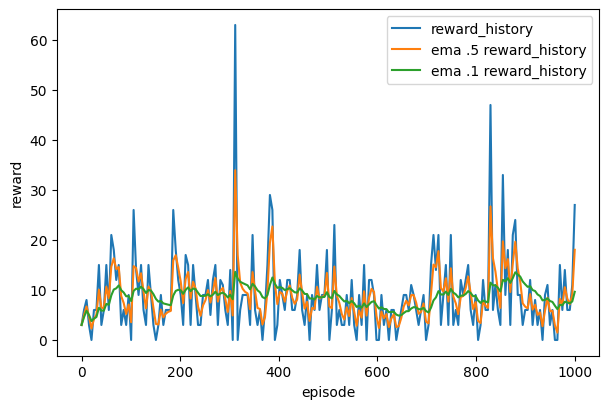

In [87]:
if is_run_model:
    fig = plt.figure(figsize=(7, 4.5))
    ax = fig.add_subplot(111)
    test_play_episode_reward_history = np.array(test_play_episode_reward_history)

    ax.plot(
        np.linspace(0, max_episode, len(test_play_episode_reward_history)),
        test_play_episode_reward_history,
        label=f"reward_history",
    )

    ax.plot(
        np.linspace(0, max_episode, len(test_play_episode_reward_history)),
        exponentiaMoveingAverageBias(test_play_episode_reward_history, 0.5),
        label=f"ema .5 reward_history",
    )

    ax.plot(
        np.linspace(0, max_episode, len(test_play_episode_reward_history)),
        exponentiaMoveingAverageBias(test_play_episode_reward_history, 0.1),
        label=f"ema .1 reward_history",
    )

    ax.set_xlabel("episode")
    ax.set_ylabel("reward")
    ax.legend()
    plt.show()

# evaluation model

## policy net

In [102]:
test_play_episode_reward_history = []

In [103]:
for i in range(1000):
    test_env = MoveTheBoxGameEnvironment()
    test_play_episode_reward, _, _, _ = policy_play(policy_net, test_env)
    test_play_episode_reward_history.append(test_play_episode_reward)

In [104]:
np.mean(test_play_episode_reward_history)

9.101

## policy net 1

In [105]:
policy_net1 = DQN(board_height, board_width, num_actions).to(device)
policy_net1.load_state_dict(torch.load("policy_net_move_select2.pth"))

<All keys matched successfully>

In [106]:
test_play_episode_reward_history = []

In [107]:
for i in range(1000):
    test_env = MoveTheBoxGameEnvironment()
    test_play_episode_reward, _, _, _ = policy_play(policy_net1, test_env)
    test_play_episode_reward_history.append(test_play_episode_reward)

In [108]:
np.mean(test_play_episode_reward_history)

9.362

#### q value

In [47]:
test_env = MoveTheBoxGameEnvironment()

In [48]:
state = test_env.getGameState()
state = torch.tensor([[state]], dtype=torch.float, device=device)

In [49]:
policy_net(state)

tensor([[ 4.5635e+01, -2.1488e+02, -4.0217e+02,  1.5932e+02,  2.1992e+02,
          1.2761e+01,  3.8557e+01,  7.4897e+00,  1.7324e+01, -7.9983e-01,
          2.8602e+01, -8.5781e-01,  3.4861e-01, -2.2343e+00, -2.8722e-01,
         -1.5473e+00, -2.3604e+00,  5.0139e+01, -2.7860e+01,  4.3705e+01,
          6.4481e+01,  1.6866e+02,  3.0301e+01,  3.1649e+01,  2.8819e+01,
          4.3100e+01,  2.3755e+01,  2.9891e+01,  5.4369e-01, -2.0072e-01,
          1.0017e-01, -2.2957e-01, -5.8599e-01, -2.0012e+00,  3.9187e+01,
          2.7029e+01,  1.7863e+01,  4.5861e+01, -1.1926e+01,  4.2587e+01,
          2.9019e+01,  5.2255e+01,  4.8508e+01, -5.4130e-01,  4.9799e+01,
         -1.1796e+00, -8.1298e-01, -4.9706e-01, -3.1130e-01, -1.9668e+00,
         -2.1559e-01,  3.0504e+01, -2.4766e+01, -3.9205e+01,  2.8551e+01,
         -2.6743e+01,  2.3400e+01,  2.0774e+01,  3.3974e+01,  4.5291e+01,
          7.9556e-02,  4.4887e+01, -9.6478e-03,  2.0748e+00, -2.3740e+00,
          1.4026e-02, -3.4093e-01, -6.

In [50]:
policy_net1(state)

tensor([[ 4.0575e+01, -2.4909e+02, -4.3364e+02,  1.3673e+02,  1.8462e+02,
          1.6506e+01,  2.8765e+01,  2.0049e+00,  2.0176e+01, -1.1728e+00,
          2.1561e+01, -1.1861e+00,  1.6301e+00, -3.1030e+00, -6.0786e-01,
         -2.0009e+00, -2.5725e+00,  4.1139e+01, -5.3969e+01,  2.0646e+01,
          5.3064e+01,  1.4157e+02,  2.4091e+01,  1.7008e+01,  2.3015e+01,
          3.9342e+01,  1.2974e+01,  2.4832e+01,  8.8200e-01, -6.0259e-02,
         -2.1642e-01, -1.1222e+00, -9.9272e-01, -1.5707e+00,  3.0718e+01,
          1.1171e+01, -8.7808e+00,  3.1376e+01, -2.1666e+01,  3.8058e+01,
          2.3153e+01,  4.9375e+01,  5.2800e+01, -1.2940e+00,  5.4905e+01,
         -2.7110e+00, -4.0801e-02, -7.8087e-01,  2.9090e-02, -1.5858e+00,
          2.3449e+00,  2.8911e+01, -4.7208e+01, -6.3096e+01,  2.3685e+01,
         -5.1167e+01,  1.7236e+01,  1.9969e+01,  3.6601e+01,  5.2822e+01,
         -2.3822e-01,  5.0769e+01,  4.8851e-02,  6.6428e-01, -2.3076e+00,
          1.5378e-01, -1.1460e+00, -3.

# test policy play

In [51]:
test_env = MoveTheBoxGameEnvironment()

In [52]:
_, temp_board_history, move_history, score_history = policy_play(policy_net, test_env)

## animation

In [53]:
fig = plt.figure(figsize=(3.5, 4.5))
ax = fig.add_subplot(111)
plt.close(fig)

ani = FuncAnimation(
    fig,
    replay_animate,
    frames=len(temp_board_history),
    interval=500,
    repeat=False,
)

HTML(ani.to_jshtml())

In [54]:
if is_save_policy_ani:
    from matplotlib.animation import PillowWriter

In [55]:
# Save the animation as an animated GIF
if is_save_policy_ani:
    ani.save(policy_ani_path, dpi=300, writer=PillowWriter(fps=1))

# test random play

In [56]:
test_env = MoveTheBoxGameEnvironment()

In [57]:
_, temp_board_history, move_history, score_history = random_play(test_env)

## animation

In [58]:
fig = plt.figure(figsize=(3.5, 4.5))
ax = fig.add_subplot(111)
plt.close(fig)

ani = FuncAnimation(
    fig,
    replay_animate,
    frames=len(temp_board_history),
    interval=500,
    repeat=False,
)

HTML(ani.to_jshtml())